<a href="https://colab.research.google.com/github/Peeeeng/BigData-Project/blob/main/%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import re
import pandas as pd

src = "/content/games_march2025_cleaned.csv"   # 원본 파일 경로
dst = "/content/games_march2025_fixed.csv"     # 고친 파일 저장 경로

lines = []
with open(src, "r", encoding="utf-8-sig", errors="ignore") as f:
    lines = f.readlines()

# 헤더 줄 기준으로 "정상 줄"의 탭 개수 추정
header = lines[0]
sep = ","   # 만약 콤마 구분자면 sep = "," 로 바꿔
base_sep_count = header.count(sep)
print("기준 구분자 개수:", base_sep_count)

fixed_lines = [header]

for line in lines[1:]:
    # 이 줄의 구분자 개수
    sep_count = line.count(sep)

    # 1) 구분자가 1개 부족하고
    # 2) 줄 안에 YYYY-MM-DD 패턴이 있을 때만 "깨진 줄"이라고 가정
    if sep_count == base_sep_count - 1 and re.search(r"\d{4}-\d{2}-\d{2}", line):
        # 이름+날짜가 한 칸에 붙어있는 형태:
        #   <name><date>\t<나머지>
        m = re.match(r"^(.*?)(\d{4}-\d{2}-\d{2}" + re.escape(sep) + r".*)$", line)
        if m:
            fixed_line = m.group(1) + sep + m.group(2)
            # 디버깅용 출력 (원하면 주석 처리)
            # print("FIXED:", fixed_line.strip())
            fixed_lines.append(fixed_line)
        else:
            # 패턴이 안 맞으면 그냥 원본 유지
            fixed_lines.append(line)
    else:
        fixed_lines.append(line)

# 고친 내용 새 파일로 저장
with open(dst, "w", encoding="utf-8-sig", newline="") as f:
    f.writelines(fixed_lines)

print("완료: fixed 파일 저장 →", dst)

# 고쳐진 파일을 DataFrame으로 로드
df = pd.read_csv(dst, sep=sep, encoding="utf-8-sig", engine='python', on_bad_lines='warn')

# genres → 문자열로 정제 (괄호, 따옴표 제거)
df['genres_clean'] = (
    df['genres']
    .astype(str)
    .str.replace(r"[\['\]]", "", regex=True)
    .str.split(',')
)

df['categories_clean'] = df['categories'].astype(str).str.replace(r"[\['\]]", "", regex=True)

df['is_multiplayer'] = df['categories_clean'].str.contains("Multi-player|Online PvP|Co-op", case=False, regex=True)
df['is_singleplayer'] = df['categories_clean'].str.contains("Single-player", case=False, regex=True)

# main_genre = 가장 첫 장르
df['main_genre'] = df['genres_clean'].apply(lambda x: x[0].strip() if isinstance(x, list) and len(x)>0 else None)


기준 구분자 개수: 46
완료: fixed 파일 저장 → /content/games_march2025_fixed.csv


/tmp/ipython-input-2624779391.py:47: ParserWarning: Skipping line 3984: unexpected end of data

  df = pd.read_csv(dst, sep=sep, encoding="utf-8-sig", engine='python', on_bad_lines='warn')


In [13]:
import re
import pandas as pd

src = "/content/games_march2025_cleaned.csv"   # 원본 파일 경로
mid = "/content/games_march2025_fixed.csv"     # 구분자/열 깨짐 고친 중간 파일
dst = "/content/games_march2025_preprocessed.csv"  # 최종 전처리 완료본

# 1) 줄 단위로 읽어서 name+date 붙은 줄 자동 수정
lines = []
with open(src, "r", encoding="utf-8-sig", errors="ignore") as f:
    lines = f.readlines()

header = lines[0]
sep = ","   # 콤마 구분자면 sep = "," 로 바꿔!
base_sep_count = header.count(sep)
print("기준 구분자 개수:", base_sep_count)

fixed_lines = [header]

for line in lines[1:]:
    sep_count = line.count(sep)

    # 1) 구분자가 1개 부족하고 + 2) YYYY-MM-DD 패턴이 있는 줄만 깨진 줄로 가정
    if sep_count == base_sep_count - 1 and re.search(r"\d{4}-\d{2}-\d{2}", line):
        # <name><date>\t<나머지> 형태를 <name>\t<date>\t<나머지> 로
        m = re.match(r"^(.*?)(\d{4}-\d{2}-\d{2}" + re.escape(sep) + r".*)$", line)
        if m:
            fixed_line = m.group(1) + sep + m.group(2)
            fixed_lines.append(fixed_line)
        else:
            fixed_lines.append(line)
    else:
        fixed_lines.append(line)

# 중간 파일 저장
with open(mid, "w", encoding="utf-8-sig", newline="") as f:
    f.writelines(fixed_lines)

print("1단계 완료: 깨진 라인 수정 →", mid)

# 2) 중간 파일을 pandas로 읽어서 DataFrame 만들기
df = pd.read_csv(mid, sep=sep, encoding="utf-8-sig", engine='python', on_bad_lines='warn')

# 3) genres / categories 전처리

# genres → 문자열로 정제 (괄호, 따옴표 제거 후 리스트로)
df['genres_clean'] = (
    df['genres']
    .astype(str)
    .str.replace(r"[\['\]]", "", regex=True)
    .str.split(',')
)

# main_genre = 가장 첫 장르
df['main_genre'] = df['genres_clean'].apply(
    lambda x: x[0].strip() if isinstance(x, list) and len(x) > 0 else None
)

# categories 정제
df['categories_clean'] = df['categories'].astype(str).str.replace(r"[\['\]]", "", regex=True)
df['is_multiplayer'] = df['categories_clean'].str.contains(
    "Multi-player|Online PvP|Co-op", case=False, regex=True
)
df['is_singleplayer'] = df['categories_clean'].str.contains(
    "Single-player", case=False, regex=True
)

# 4) 최종 저장
df.to_csv(dst, index=False, encoding="utf-8-sig")
print("2단계 완료: 전처리된 CSV 저장 →", dst)


기준 구분자 개수: 46
1단계 완료: 깨진 라인 수정 → /content/games_march2025_fixed.csv


/tmp/ipython-input-1993508192.py:42: ParserWarning: Skipping line 3984: unexpected end of data

  df = pd.read_csv(mid, sep=sep, encoding="utf-8-sig", engine='python', on_bad_lines='warn')


2단계 완료: 전처리된 CSV 저장 → /content/games_march2025_preprocessed.csv


In [14]:
# release_date를 날짜 형식으로 통일
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# year 컬럼 생성
df['year'] = df['release_date'].dt.year

# 날짜가 없는 게임 제거
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)


In [15]:
# 장르에서 첫 번째 장르만 추출
df['main_genre'] = df['genres'].str.split(',').str[0].str.strip()

# 비슷한 장르 자동 통합 dictionary
genre_map = {
    'Action RPG': 'RPG',
    'Action-Adventure': 'Action',
    'Indie Adventure': 'Adventure',
    'Casual Simulation': 'Simulation',
    'Strategy RPG': 'RPG',
    'Sports': 'Sports',
    'Racing': 'Racing',
    'Adventure': 'Adventure',
    'Indie': 'Indie',
    # 필요시 계속 추가
}

df['main_genre'] = df['main_genre'].replace(genre_map)


In [16]:
# negative 컬럼을 숫자형으로 변환 (변환 불가 값은 NaN 처리 후 0으로 채움)
df['negative'] = pd.to_numeric(df['negative'], errors='coerce').fillna(0).astype(int)

df['total_reviews'] = df['positive'] + df['negative']

In [17]:
# 게임 이름 기준 중복 제거
df = df.drop_duplicates(subset='name')

# 중요한 컬럼 결측치 제거
df = df.dropna(subset=['main_genre', 'total_reviews', 'price'])


In [18]:
df.to_csv('/content/steam_cleaned (3).csv', index=False)
print("전처리 완료된 CSV 저장 완료!")


전처리 완료된 CSV 저장 완료!


In [19]:
print(df.columns)
print(df.head(3))


Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'discount',
       'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total',
       'pct_pos_recent', 'num_reviews_recent', 'genres_clean', 'main_genre',
       'categories_clean', 'is_multiplayer', 'is_singleplayer', 'year',
       'total_reviews'],
      dtype='object')
    appid                 na

In [21]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv(
    '/content/games_march2025_fixed.csv',   # 파일 경로
    engine='python',
    encoding='utf-8-sig',
    #quotechar="'",          # 리스트 문자열은 ' 로 감싸짐
    #escapechar="\\",         # 내부 특수문자 보호
    on_bad_lines='warn',
    sep=","
)

# 1) 필요한 컬럼만 남기기
columns_to_keep = [
    'name',
    'release_date',
    'genres',
    'categories',
    'price',
    'positive',
    'negative',
    'num_reviews_total',
    'estimated_owners',
    'peak_ccu'
]

print(df.columns)
print(df.head(3))
print("\n")
df = df[columns_to_keep]
df.head()
print("필요한 컬럼만 남긴 후 df.info():")
print(df.info())

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'discount',
       'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total',
       'pct_pos_recent', 'num_reviews_recent'],
      dtype='object')
    appid                 name release_date  required_age  price  dlc_count  \
0     730     Counter-Strike 2   2012-08-21             0    0.0          1

/tmp/ipython-input-3060298779.py:4: ParserWarning: Skipping line 3984: unexpected end of data

  df = pd.read_csv(


-----------


In [22]:
import pandas as pd

# 0. 데이터 불러오기
df = pd.read_csv("/content/steam_cleaned (3).csv", encoding="utf-8")

print(df.columns)
df.head()


Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'discount',
       'peak_ccu', 'tags', 'pct_pos_total', 'num_reviews_total',
       'pct_pos_recent', 'num_reviews_recent', 'genres_clean', 'main_genre',
       'categories_clean', 'is_multiplayer', 'is_singleplayer', 'year',
       'total_reviews'],
      dtype='object')


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,num_reviews_total,pct_pos_recent,num_reviews_recent,genres_clean,main_genre,categories_clean,is_multiplayer,is_singleplayer,year,total_reviews
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,8632939,82,96473,"['Action', ' Free To Play']",['Action',"Multi-player, Cross-Platform Multiplayer, Stea...",True,False,2012,8615921
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,2513842,68,16720,"['Action', ' Adventure', ' Massively Multiplay...",['Action',"Multi-player, PvP, Online PvP, Stats, Remote P...",True,False,2017,2512396
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,2452595,80,29366,"['Action', ' Strategy', ' Free To Play']",['Action',"Multi-player, Co-op, Steam Trading Cards, Stea...",True,False,2013,2449800
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,1803832,92,17517,"['Action', ' Adventure']",['Action',"Single-player, Multi-player, PvP, Online PvP, ...",True,True,2015,1969962
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,3.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,1168020,76,12608,['Action'],['Action'],"Single-player, Multi-player, PvP, Online PvP, ...",True,True,2015,1371209


In [23]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year


In [24]:
# genres 문자열 정리해서 리스트로
df['genres_clean'] = (
    df['genres']
    .astype(str)
    .str.replace(r"[\[\]']", "", regex=True)   # [ ] ' 제거
    .str.split(',')                            # 콤마로 split
)

# 대표 장르 = 첫 번째 장르
df['main_genre'] = df['genres_clean'].apply(
    lambda x: x[0].strip() if isinstance(x, list) and len(x) > 0 else None
)


In [25]:
df['categories_clean'] = df['categories'].astype(str).str.replace(r"[\[\]']", "", regex=True)

df['is_multiplayer'] = df['categories_clean'].str.contains(
    "Multi-player|Online PvP|Co-op", case=False, regex=True
)
df['is_singleplayer'] = df['categories_clean'].str.contains(
    "Single-player", case=False, regex=True
)


In [26]:
def parse_owner_range(s):
    try:
        low = s.split('-')[0].strip().replace(" ", "")
        return int(low)
    except Exception:
        return None

df['owners_est'] = df['estimated_owners'].apply(parse_owner_range)


In [27]:
# 이름, 날짜, 장르 없는 게임 제거
df = df.dropna(subset=['name', 'release_date', 'main_genre'])

# 게임 이름 기준 중복 제거
df = df.drop_duplicates(subset=['name'])


name                 → 게임 이름
release_date         → 출시 날짜
year                 → 출시 연도
genres               → 원본 장르 목록
main_genre           → 대표 장르
categories           → 원본 카테고리 목록
categories_clean     → 정제된 카테고리 문자열
is_multiplayer       → 멀티 여부
is_singleplayer      → 싱글 여부
price                → 가격
positive             → 긍정 리뷰 수
negative             → 부정 리뷰 수
num_reviews_total    → 원본 총 리뷰 수
total_reviews        → 긍정+부정 총 리뷰 수
estimated_owners     → 추정 소유자 범위
owners_est           → 추정 소유자(숫자)
peak_ccu             → 최대 동접자

| 컬럼명              | 한국어 설명      |
| ---------------- | ----------- |
| **name**         | 게임 이름       |
| **release_date** | 출시 날짜       |
| **year**         | 출시 연도 (숫자만) |
| -------------- | ---------------------- |
| **genres**     | 원본 장르 목록(문자열 리스트 형태)   |
| **main_genre** | 대표 장르 (첫 번째 장르만 정제한 값) |
| **genres_clean** | 정제된 장르 리스트 |
| -------------------- | ------------------------ |
| **categories**       | 원본 카테고리 목록               |
| **categories_clean** | 괄호/따옴표 제거된 정제된 카테고리      |
| **is_multiplayer**   | 멀티플레이 가능 여부 (True/False) |
| **is_singleplayer**  | 싱글플레이 가능 여부 (True/False) |
| --------- | ------------ |
| **price** | 게임 가격(달러 기준) |
| --------------------- | ----------------- |
| **positive**          | 긍정 평가 수           |
| **negative**          | 부정 평가 수           |
| **num_reviews_total** | 총 리뷰 수(원본 데이터 기준) |
| **total_reviews**     | 긍정+부정 합산한 총 리뷰 수  |
| -------------------- | ------------------------- |
| **estimated_owners** | 추정 소유자 범위 (문자열)           |
| **owners_est**       | 추정 소유자 수(범위의 최소값만 숫자로 변환) |
| **peak_ccu**         | 최대 동시 접속자 수(CCU)          |


In [28]:
df_pop = df[df['total_reviews'] >= 1000].copy()
print(len(df), "→ 필터 후:", len(df_pop))


3958 → 필터 후: 3637


In [29]:
genre_year = (
    df_pop
    .groupby(['year', 'main_genre'])
    .agg(
        games=('name', 'nunique'),          # 그 해 그 장르 게임 수
        total_reviews=('total_reviews', 'sum'),  # 그 해 그 장르 리뷰 총합
        avg_reviews=('total_reviews', 'mean')    # 게임당 평균 리뷰 수
    )
    .reset_index()
)

genre_year.head()


,year,main_genre,games,total_reviews,avg_reviews
0,1997,Action,1,10448,10448.0
1,1999,Action,1,8621,8621.0
2,2001,Action,1,15371,15371.0
3,2002,Action,1,14978,14978.0
4,2004,Action,2,193463,96731.5


In [30]:
pivot_counts = genre_year.pivot(index='year', columns='main_genre', values='games').fillna(0)
pivot_reviews = genre_year.pivot(index='year', columns='main_genre', values='total_reviews').fillna(0)


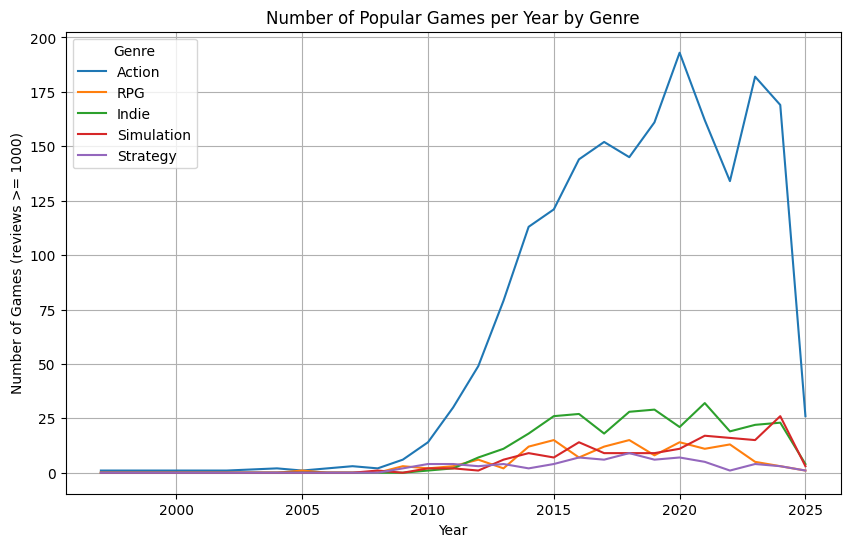

In [31]:
import matplotlib.pyplot as plt

# 연도별로 Action / RPG / Indie 같은 몇 개만 골라서 라인그래프

target_genres = ['Action', 'RPG', 'Indie', 'Simulation', 'Strategy']

pivot_counts[target_genres].plot(kind='line', figsize=(10,6))
plt.title("Number of Popular Games per Year by Genre")
plt.xlabel("Year")
plt.ylabel("Number of Games (reviews >= 1000)")
plt.legend(title="Genre")
plt.grid(True)
plt.show()
